# Developping notebook - Network times

This notebook is used to search for a __more efficient way to create a nodes_distance_matrix:__ A table containing times from each node to all the other nodes within a network.

## __Import libraries__

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    print(f"Path found.")
    sys.path.append(module_path)
    import aup
else:
    print(f"Path already loaded.")
    import aup

repo_path = str(module_path)+"/"
print(f"Repo path: {repo_path}")

Path found.
Repo path: /home/jovyan/accesibilidad-urbana/


## __Notebook config__

In [3]:
# ----- ----- ----- Input configuration
project_path = repo_path + "data/projects/30_taojuan/"

## __Load test nodes and edges__

In [29]:
# Load nodes
nodes_gdf = gpd.read_file(project_path+"/network_test/taoyuan_nodes_test.gpkg")
if nodes_gdf.crs != "EPSG:4326":
    nodes_gdf = nodes_gdf.to_crs("EPSG:4326")

# Show
print(nodes_gdf.osmid.unique())
print(nodes_gdf.crs)
print(nodes_gdf.shape)
nodes_gdf.head(2)

[9211414626 9211458042 9211458099 9211458109 9211458134 9211458223
 9211458235 9211458291 9211458293 9211458326 9211458327 9211458358
 9211458372 9211458523]
EPSG:4326
(14, 5)


,osmid,x,y,street_count,geometry
0,9211414626,121.305754,24.592593,3,POINT (121.30575 24.59259)
1,9211458042,121.302056,24.589918,3,POINT (121.30206 24.58992)


In [5]:
# Load edges
edges_gdf = gpd.read_file(project_path+"/network_test/taoyuan_edges_test.gpkg")
if edges_gdf.crs != "EPSG:4326":
    edges_gdf = edges_gdf.to_crs("EPSG:4326")

# Show
print(edges_gdf.crs)
print(edges_gdf.shape)
edges_gdf.head(2)

EPSG:4326
(26, 18)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,bridge,ref,junction,tunnel,access,width,service,geometry
0,9211414626,9211458042,0,184743243,False,None,新光道路,tertiary,None,551.239249,None,竹60,None,None,None,None,None,"LINESTRING (121.30575 24.59259, 121.30574 24.5..."
1,9211414626,9211458223,0,997617586,False,None,None,track,None,1145.022486,None,None,None,None,None,None,None,"LINESTRING (121.30575 24.59259, 121.30580 24.5..."


<Axes: >

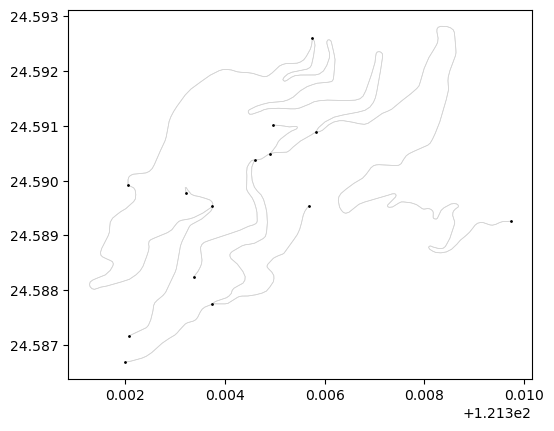

In [6]:
fig,ax = plt.subplots()

nodes_gdf.plot(ax=ax,zorder=1,markersize=1,color='black')
edges_gdf.plot(ax=ax,zorder=0,linewidth=0.5,edgecolor='lightgray')

## __Exploration__

In [49]:
# Create g (network), weights (array with lengths) and node_mapping (series with osmid-index)
wght = 'length'
g, weights, node_mapping = aup.to_igraph(nodes_gdf, #Network nodes
                                         edges_gdf, #Network edges
                                         wght=wght) #Column with distance/time
weights

array([ 551.23924911, 1145.02248638,  551.23924911,  608.28377043,
         83.73337777,  608.28377043,  331.62792734,   83.73337777,
        331.62792734,  106.52133925, 1145.02248638, 1560.81332462,
        396.14689225,   32.70982252,  333.34456836,  220.00723224,
        220.00723224,  396.14689225,  331.08686205,  331.08686205,
        333.34456836,   32.70982252,  106.52133925,  129.55890849,
        129.55890849, 1560.81332462])

In [50]:
node_mapping

{9211414626: 0,
 9211458042: 1,
 9211458099: 2,
 9211458109: 3,
 9211458134: 4,
 9211458223: 5,
 9211458235: 6,
 9211458291: 7,
 9211458293: 8,
 9211458326: 9,
 9211458327: 10,
 9211458358: 11,
 9211458372: 12,
 9211458523: 13}

In [88]:
# Create an array of points of interest indexes (Just the first two nodes to show possibilities)
if 'osmid' not in nodes_gdf.columns:
    nodes_gdf.reset_index(inplace=True)
seeds = aup.get_seeds(nodes_gdf.iloc[0:2], #Points of interest
                      node_mapping,
                      column_name='osmid') #Column with index to which relate nearest distance

seeds

array([0, 1])

In [81]:
# Looks for the shortest path between the current node in g and the seed (points of interest, each node)
shortest_paths = np.array(g.shortest_paths_dijkstra(seeds,weights=weights))
# Reduce decimal places
shortest_paths = np.round(shortest_paths, 2)

# Show
shortest_paths

array([[   0.  ,  551.24, 1159.52, 1243.26, 1491.15, 1145.02, 1284.25,
        1900.41, 1680.4 , 2011.49, 1617.6 , 1251.54, 1381.1 , 2705.84],
       [ 551.24,    0.  ,  608.28,  692.02,  939.91, 1696.26, 1835.49,
        2451.65, 2231.64, 2562.73, 2168.84, 1802.78, 1932.34, 3257.08]])

In [75]:
#voronoi_assignment = aup.voronoi_cpu(g, weights, seeds)
#distances = [np.min(shortest_paths[:,i]) for i in range(len(voronoi_assignment))]
#distances

In [87]:
# Create shortest path dataframe
all_osmids = list(node_mapping.keys())
poi_osmids = list(nodes_gdf.iloc[seeds].osmid.unique())
df = pd.DataFrame(shortest_paths, columns=all_osmids, index=poi_osmids)

df

,9211414626,9211458042,9211458099,9211458109,9211458134,9211458223,9211458235,9211458291,9211458293,9211458326,9211458327,9211458358,9211458372,9211458523
9211414626,0.00,551.24,1159.52,1243.26,1491.15,1145.02,1284.25,1900.41,1680.40,2011.49,1617.60,1251.54,1381.10,2705.84
9211458042,551.24,0.00,608.28,692.02,939.91,1696.26,1835.49,2451.65,2231.64,2562.73,2168.84,1802.78,1932.34,3257.08
